In [ ]:
!mkdir data
!wget https://github.com/yk4r2/AAA/blob/main/Experiments/homeworks/HW4/data/apartaments_dev.tar.gz?raw=true -O data/apartaments_dev.tar.gz

--2021-04-15 23:20:24--  https://github.com/yk4r2/AAA/blob/main/Experiments/homeworks/HW4/data/apartaments_dev.tar.gz?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yk4r2/AAA/raw/main/Experiments/homeworks/HW4/data/apartaments_dev.tar.gz [following]
--2021-04-15 23:20:24--  https://github.com/yk4r2/AAA/raw/main/Experiments/homeworks/HW4/data/apartaments_dev.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yk4r2/AAA/main/Experiments/homeworks/HW4/data/apartaments_dev.tar.gz [following]
--2021-04-15 23:20:24--  https://raw.githubusercontent.com/yk4r2/AAA/main/Experiments/homeworks/HW4/data/apartaments_dev.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...


In [ ]:
!tar -xf ./data/apartaments_dev.tar.gz -C data

In [ ]:
!pip install pingouin

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import json
import re
from scipy import stats

import pingouin as pg

from statsmodels.stats.multicomp import pairwise_tukeyhsd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Финальный срок сдачи: 16 апреля 21:00**

Вы работаете аналитиком в вертикали Недвижимость. Было решено развивать сегмент «Апартаменты» и
первыми продуктовыми инициативами запущенными в тест были:
- добавление чекбокса «Апартаменты в фильтр поиска;
- добавление быстрого фильтра в поиске:
    - «Однокомнатные апартаменты»
    - «Двухкомнатные апартаменты» и т.д.
- добавление планировки на карточку объявлений;
Для быстрой проверки гипотез было решено провести факторный эксперимент 
следующей конфигурации(одна строка — одна тестовая группа):
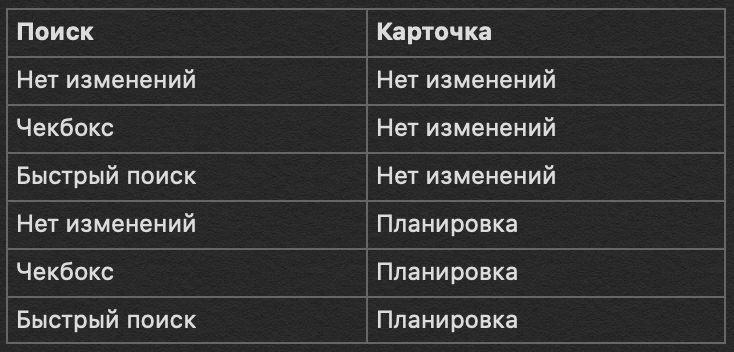


Есть гипотеза, что эти изменения приведут к росту конверсии из посетителя в покупателя.
Также есть дополнительная гипотеза о том, что изменения на поиске будут приводить к изменению структуры трафика на карточке и соответственно к изменению эффекта от улучшений на карточке.

Вам необходимо провести анализ эксперимента.

1. Сформирулируйте и формализуйте проверяемые продуктовые гипотезы. (2 балла)
2. Загрузите данные и постройте график распределений, по цвету раздели изменения на поиске, по строкам изменения на карточке. Попробуй проинтерпретировать изменения на основе визуального анализа. (2 балла)
3. Примени двухфакторную ANOVA и оцени изменения. (2 балла)
4. Примени критерий Тьюкки для нахождения парных изменений. (2 балла)
5. Сделайте продуктовые выводы по результатам эксперимента. (2 балла)


cookie_id - ид пользователя

split_group	- тестовая группа

searches - количество поисков

item_views - количество просмотров объявлений

changes_in_search - изменение в поиске

changes_in_item - изменение в на карточке


In [ ]:
df = pd.read_csv('data/apartaments_dev.csv')

In [ ]:
df.sample(5)

,cookie_id,searches,item_views,contacts,changes_in_search,changes_in_item
566757,3351047176779,2,7,0,checkbox,no_changes
1572147,3942559549525,1,0,0,fast_search,no_changes
1069652,3953389520890,0,2,1,checkbox,no_changes
1650653,3919332004825,3,3,0,fast_search,no_changes
2728653,3954099513954,24,27,0,checkbox,add_plan


In [ ]:
df.describe()

,cookie_id,searches,item_views,contacts
count,3.315726e+06,3.315726e+06,3.315726e+06,3.315726e+06
mean,3.452371e+12,3.695403e+01,3.224695e+01,1.058361e+00
std,8.080391e+11,1.674618e+02,1.476740e+02,9.692643e+00
min,7.293193e+08,0.000000e+00,0.000000e+00,-3.000000e+00
25%,3.415032e+12,2.000000e+00,2.000000e+00,0.000000e+00
50%,3.813410e+12,6.000000e+00,6.000000e+00,0.000000e+00
75%,3.923957e+12,2.100000e+01,2.200000e+01,0.000000e+00
max,3.967662e+12,7.153600e+04,4.184600e+04,3.579000e+03


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3315726 entries, 0 to 3315725
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   cookie_id          int64 
 1   searches           int64 
 2   item_views         int64 
 3   contacts           int64 
 4   changes_in_search  object
 5   changes_in_item    object
dtypes: int64(4), object(2)
memory usage: 151.8+ MB


$H_0$:
- Изменения в поиске не влияют на конверсию из поиска в контакты &
- Изменения в поиске не влияют на конверсию из просмотров объявления в контакты &
- Нет взаимодействия между факторами

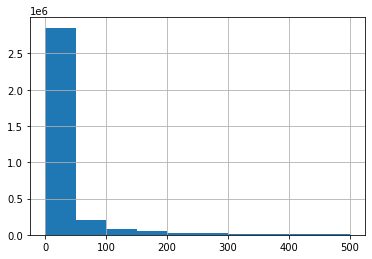

In [ ]:
df[df['searches'] <= 500].searches.hist()

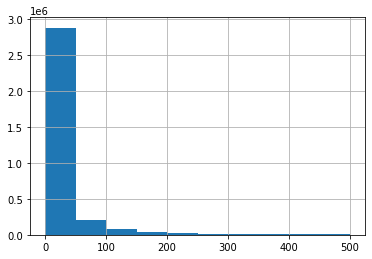

In [ ]:
df[df['item_views'] <= 500].item_views.hist()

In [ ]:
df_no_outliers = df[(df['item_views'] <= 500) & (df['searches'] <= 500) & (df['contacts'] <= 15)]

In [ ]:
df_no_outliers[df_no_outliers['contacts'] < 0]

,cookie_id,searches,item_views,contacts,changes_in_search,changes_in_item
1657252,263807349197,59,148,-1,no_changes,add_plan
1657259,273308029439,1,1,-1,no_changes,add_plan
1657262,276252783391,76,12,-1,no_changes,add_plan
1657303,303353100025,81,6,-1,no_changes,add_plan
1657308,306261332740,32,8,-1,no_changes,add_plan
...,...,...,...,...,...,...
2210093,3963779516539,5,1,-1,no_changes,add_plan
2210108,3965314528967,1,32,-1,no_changes,add_plan
2210117,3965522030149,3,5,-1,no_changes,add_plan
2210142,3965852026129,2,2,-1,no_changes,add_plan


Отрицательные контакты??? Давайте дропнем на всякий и построим людей только с контактами > 0

In [ ]:
df_no_outliers = df_no_outliers[df_no_outliers['contacts'] >= 0]

In [ ]:
df_with_contacts = df_no_outliers[df_no_outliers['contacts'] > 0]

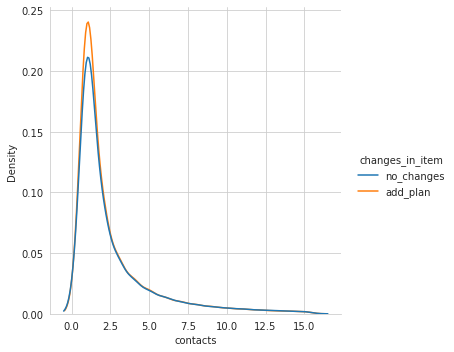

In [ ]:
sns.set_style('whitegrid')
sns.displot(data=df_with_contacts, x='contacts', hue='changes_in_item', kind='kde', bw_adjust=2.5)

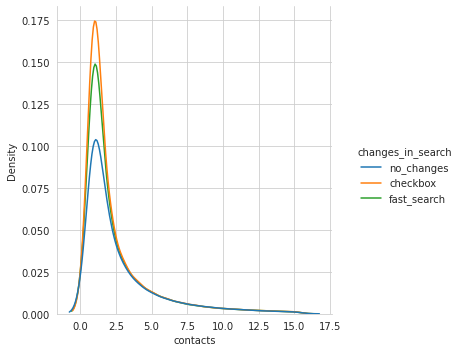

In [ ]:
sns.displot(data=df_with_contacts, x='contacts', hue='changes_in_search', kind='kde', bw_adjust=2.5)

Как будто бы что-то подрастает. Давайте сделаем предложенный графичек.

Загрузи данные и построй график распределений, по цвету раздели изменения на поиске, по строкам изменения на карточке. Попробуй проинтерпретировать изменения на основе визуального анализа.

In [ ]:
df_with_contacts.changes_in_item.unique()

array(['no_changes', 'add_plan'], dtype=object)

In [ ]:
from matplotlib.pyplot import figure

<Figure size 2304x648 with 0 Axes>

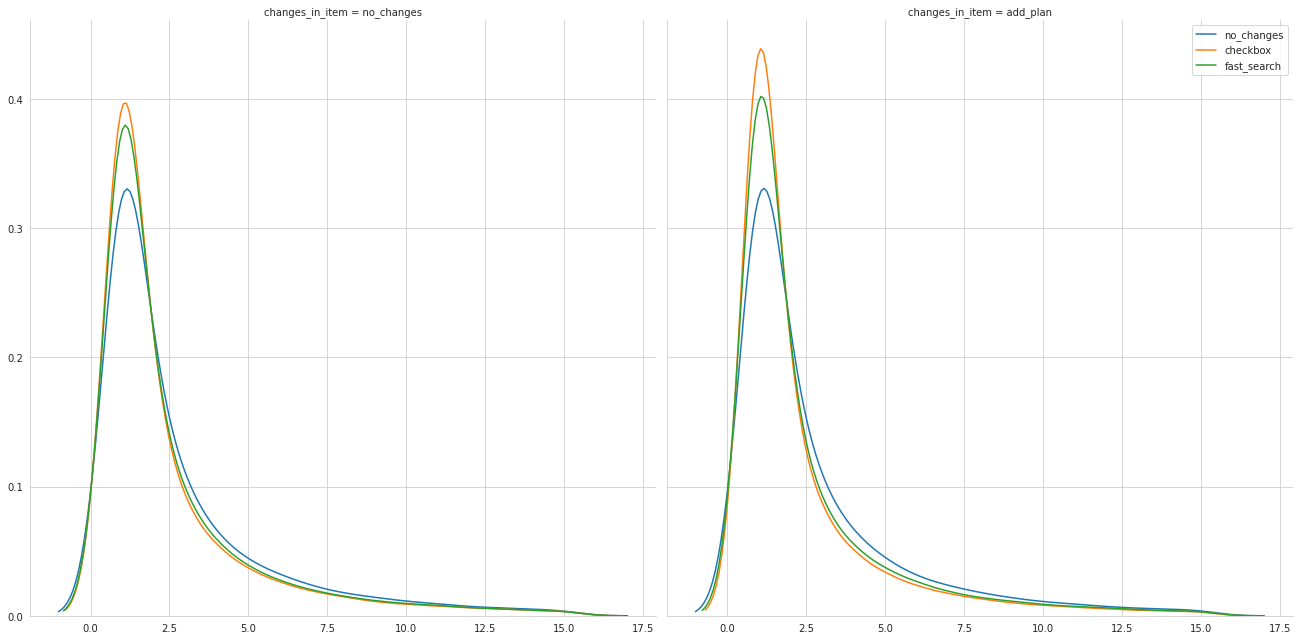

In [ ]:
figure(figsize=(32, 9))
g = sns.FacetGrid(df_with_contacts, col="changes_in_item", hue="changes_in_search", col_wrap=3, height=9)
g.map_dataframe(sns.kdeplot, x="contacts", bw_adjust=2.5)
g.axes[-1].legend()
plt.show()

`checkbox` и `add_plan` сильно лучше работают как будто бы

In [ ]:
aov = pg.anova(dv='contacts', between=['changes_in_search', 'changes_in_item'], data=df_no_outliers, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,changes_in_search,3.047436e+03,2.0,1523.717833,560.123387,6.076565e-244,0.000347
1,changes_in_item,3.463059e+02,1.0,346.305853,127.303102,1.596648e-29,0.000039
2,changes_in_search * changes_in_item,1.298597e+02,2.0,64.929868,23.868420,4.306787e-11,0.000015
3,Residual,8.790829e+06,3231536.0,2.720325,NaN,NaN,NaN


Pvalue малы -> связи нет

In [ ]:
groups = df_no_outliers['changes_in_search'] + ' ' + df_no_outliers['changes_in_item']

In [ ]:
print(pairwise_tukeyhsd(endog=df_no_outliers['contacts'], groups=groups, alpha=0.01))

                Multiple Comparison of Means - Tukey HSD, FWER=0.01                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
     checkbox add_plan    checkbox no_changes  -0.0355  0.001 -0.0461 -0.0248   True
     checkbox add_plan   fast_search add_plan  -0.0387  0.001 -0.0493  -0.028   True
     checkbox add_plan fast_search no_changes  -0.0607  0.001 -0.0714   -0.05   True
     checkbox add_plan    no_changes add_plan  -0.0906  0.001 -0.1013 -0.0798   True
     checkbox add_plan  no_changes no_changes   -0.095  0.001 -0.1057 -0.0844   True
   checkbox no_changes   fast_search add_plan  -0.0032    0.9 -0.0139  0.0075  False
   checkbox no_changes fast_search no_changes  -0.0252  0.001 -0.0359 -0.0146   True
   checkbox no_changes    no_changes add_plan  -0.0551  0.001 -0.0658 -0.0444   True
   checkbox no_changes  no_changes no_changes  -0.0596  0.001 -0.

Выходит, что есть вероятность того, что add_plan влияет на checkbox, а при этом сам add_plan как будто бы незначительно влияет на выборку.